In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torchvision.utils
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import os
from sklearn.metrics import f1_score

In [5]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [6]:
class SiameseNetworkDataset(Dataset):
    # load in correct and false datasets
    def __init__(self,imageFolderDataset,false_dataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.false_dataset = false_dataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset[index]
        #We need to approximately 50% of images to be correct pairs
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            # in 3 out of 4 cases, choose a false image from the same stage
            # in the 1 out of 4 cases choose a false image from another stage
            include_false =random.randint(0,4)

            if include_false < 3:
                while True:
                    img1_tuple = random.choice(self.false_dataset)
                    if img0_tuple[1] == img1_tuple[1]:
                        break
            else:
                img1_tuple = random.choice(self.false_dataset)

        # convert images and transpose them if necessary
        img0 = img0_tuple[0].convert('RGB')
        width, height = img0.size
        if width > height:
            img0 = img0.transpose(Image.TRANSPOSE)
        img1 = img1_tuple[0].convert('RGB')
        width, height = img1.size
        if width > height:
            img1 = img1.transpose(Image.TRANSPOSE)
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        return img0, img1, torch.from_numpy(np.array([should_get_same_class], dtype=np.float32)), img0_tuple[1]

    def __len__(self):
        #determines the amount max amount of steps during training
        return len(self.imageFolderDataset)

In [7]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root=r"D:\PycharmProjects\AISS\siamese\dataset_true")
false_dataset = datasets.ImageFolder(root=r"D:\PycharmProjects\AISS\siamese\dataset_false")

folder_dataset_test = datasets.ImageFolder(root=r"D:\PycharmProjects\AISS\siamese\dataset_true_val")
false_dataset_test = datasets.ImageFolder(root=r"D:\PycharmProjects\AISS\siamese\dataset_false_val")

# Augment + Resize the images and transform to tensors
transformation = transforms.Compose([
                                    transforms.Resize((150, 50)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                     transforms.ToTensor()

                                    ])

transformation_test = transforms.Compose([
                                    transforms.Resize((150, 50)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                     transforms.ToTensor()
                                    ])

# Initialize the Datasets
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,false_dataset=false_dataset,
                                        transform=transformation)

siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,false_dataset=false_dataset_test,
                                        transform=transformation_test)

C:\Users\Admin\AppData\Local\Temp\ipykernel_5608\2146420725.py:33: DeprecationWarning: TRANSPOSE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.TRANSPOSE instead.
  img0 = img0.transpose(Image.TRANSPOSE)
C:\Users\Admin\AppData\Local\Temp\ipykernel_5608\2146420725.py:37: DeprecationWarning: TRANSPOSE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.TRANSPOSE instead.
  img1 = img1.transpose(Image.TRANSPOSE)


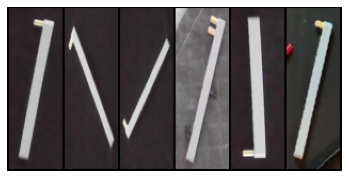

[0. 1. 1.]


In [8]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=False,
                        batch_size=3)
# Extract one batch
example_batch = next(iter(vis_dataloader))
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

In [9]:
# create dataloader
trainloader = DataLoader(siamese_dataset,
                        batch_size=128)

testloader = DataLoader(siamese_dataset_test,
                        batch_size=128)

In [10]:
next(iter(testloader))

C:\Users\Admin\AppData\Local\Temp\ipykernel_5608\2146420725.py:33: DeprecationWarning: TRANSPOSE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.TRANSPOSE instead.
  img0 = img0.transpose(Image.TRANSPOSE)
C:\Users\Admin\AppData\Local\Temp\ipykernel_5608\2146420725.py:37: DeprecationWarning: TRANSPOSE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.TRANSPOSE instead.
  img1 = img1.transpose(Image.TRANSPOSE)


[tensor([[[[0.2863, 0.2784, 0.2745,  ..., 0.3059, 0.3098, 0.3098],
           [0.2902, 0.2863, 0.2745,  ..., 0.3059, 0.3137, 0.3176],
           [0.2980, 0.2863, 0.2745,  ..., 0.3098, 0.3137, 0.3176],
           ...,
           [0.3098, 0.2902, 0.2784,  ..., 0.3059, 0.3098, 0.3059],
           [0.3216, 0.2941, 0.2863,  ..., 0.3137, 0.3137, 0.3020],
           [0.3294, 0.2980, 0.2941,  ..., 0.3176, 0.3137, 0.2980]],
 
          [[0.3686, 0.3725, 0.3765,  ..., 0.3686, 0.3725, 0.3725],
           [0.3725, 0.3765, 0.3725,  ..., 0.3725, 0.3765, 0.3804],
           [0.3765, 0.3725, 0.3686,  ..., 0.3765, 0.3804, 0.3843],
           ...,
           [0.3922, 0.3686, 0.3529,  ..., 0.3922, 0.3922, 0.3804],
           [0.4039, 0.3804, 0.3647,  ..., 0.4000, 0.3922, 0.3765],
           [0.4118, 0.3882, 0.3765,  ..., 0.4078, 0.3922, 0.3725]],
 
          [[0.4627, 0.4667, 0.4667,  ..., 0.4706, 0.4745, 0.4745],
           [0.4667, 0.4667, 0.4627,  ..., 0.4745, 0.4784, 0.4824],
           [0.4745, 0.46

In [11]:


class SiameseNetwork(nn.Module):
    def __init__(self, backbone="resnet18"):
        '''
        Creates a siamese network with a network from torchvision.models as backbone.
            Parameters:
                    backbone (str): Options of the backbone networks can be found at https://pytorch.org/vision/stable/models.html
        '''

        super().__init__()

        if backbone not in models.__dict__:
            raise Exception("No model named {} exists in torchvision.models.".format(backbone))

        # Create a backbone network from the pretrained models provided in torchvision.models
        self.backbone = models.__dict__[backbone](pretrained=True, progress=False, )

        # Create a cls head for binary crosentropy
        # we experimented with different layer sizes and number of layers

        self.cls_head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(2000, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, img1, img2):
        '''
        Returns the similarity value between two images.
            Parameters:
                    img1 (torch.Tensor): shape=[b, 3, 224, 224]
                    img2 (torch.Tensor): shape=[b, 3, 224, 224]
            where b = batch size
            Returns:
                    output (torch.Tensor): shape=[b, 1], Similarity of each pair of images
        '''

        # Pass the both images through the backbone network to get their seperate feature vectors
        feat1 = self.backbone(img1)
        feat2 = self.backbone(img2)

        # Multiply (element-wise) the feature vectors of the two images together,
        # to generate a combined feature vector representing the similarity between the two.
        #combined_features = feat1 * feat2
        combined_features = torch.cat((feat1, feat2), 1)
        # Pass the combined feature vector through classification head to get similarity value in the range of 0 to 1.
        output = self.cls_head(combined_features)
        return output

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()


for epoch in range(300):
    print("[{} / {}]".format(epoch, 300))
    model.train()

    losses = []
    correct = 0
    total = 0
    preds_tr = []
    gt_tr = []
    # Training Loop Start
    model.train()
    for img1, img2, y, _ in trainloader:
        img1, img2, y = map(lambda x: x.to(device), [img1, img2, y])
        prob = model(img1, img2)
        loss = criterion(prob, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # convert the similarity scores to binary values to evaluate
        flattened_list = [item for sublist in prob.tolist() for item in (sublist if isinstance(sublist, list) else [sublist])]
        flatt = [0 if i < 0.5 else 1 for i in flattened_list]
        preds_tr.extend(flatt)
        flattened_list = [item for sublist in y.tolist() for item in (sublist if isinstance(sublist, list) else [sublist])]
        gt_tr.extend(flattened_list)


    print("\tTraining: Loss={:.2f}\t ".format(np.mean(losses)))
    print(classification_report(gt_tr, preds_tr))
    # Training Loop End
    # Start evaluation
    model.eval()

    correct = 0
    total = 0
    preds = []
    gt = []
    all_loss = []
    for k in range(3):
        for img1, img2, y, cls in testloader:

            img1, img2, y = map(lambda x: x.to(device), [img1, img2, y])
            prob = model(img1, img2)
            all_loss.append(criterion(prob, y).item())
            # convert the similarity scores to binary values to evaluate
            flattened_list = [item for sublist in prob.tolist() for item in (sublist if isinstance(sublist, list) else [sublist])]
            flatt = [0 if i < 0.5 else 1 for i in flattened_list]
            preds.extend(flatt)
            flattened_list = [item for sublist in y.tolist() for item in (sublist if isinstance(sublist, list) else [sublist])]
            gt.extend(flattened_list)

    l = np.mean(all_loss)
    print(f"val loss: {l}")
    print(classification_report(gt, preds))
    # Evaluation Loop Start
    f = f1_score(gt, preds, average='macro')



    # Save model based on the frequency defined by "args.save_after"
    if (epoch + 1) % 1 == 0:
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "backbone": "resnet-18",
                "optimizer_state_dict": optimizer.state_dict()
            },
            os.path.join("siamese","models_new", "epoch_{}_{}.pth".format(epoch + 1, f))
        )

In [ ]:
# run the training with multiple anchor images for evaluation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()


for epoch in range(70):
    print("[{} / {}]".format(epoch, 70))
    model.train()

    losses = []
    correct = 0
    total = 0
    preds_tr = []
    gt_tr = []
    # Training Loop Start
    for img1, img2, y, _ in trainloader:
        img1, img2, y = map(lambda x: x.to(device), [img1, img2, y])
        prob = model(img1, img2)
        loss = criterion(prob, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        flattened_list = [item for sublist in prob.tolist() for item in (sublist if isinstance(sublist, list) else [sublist])]
        flatt = [0 if i < 0.5 else 1 for i in flattened_list]
        preds_tr.extend(flatt)
        flattened_list = [item for sublist in y.tolist() for item in (sublist if isinstance(sublist, list) else [sublist])]
        gt_tr.extend(flattened_list)


    print("\tTraining: Loss={:.2f}\t ".format(np.mean(losses)))
    print(classification_report(gt_tr, preds_tr))
    # Training Loop End
    correct = 0
    total = 0
    preds = []
    gt = []
    model.eval()
    # since there is a 50% chance to get a correct pair and 50% for a false pair we repeated the evaluation step 3 times to get a positive and negative pair
    for k in range(3):
        for img1, img2, y, cls in testloader:


            for ind in range(len(img1)):
                folder = r"D:\PycharmProjects\AISS\siamese\dataset_true"
                cl = cls[ind]
                img = img1[ind].cuda()
                img_ = img2[ind].cuda()
                y_ = y[ind]
                img = img[None, :]
                img_ = img_[None, :]
                # get the anchor images for the stage
                if cl == 0:
                    folder = folder + r"\0"
                    reference_imgs = [os.path.join(folder, "anchor0_1.jpg"), os.path.join(folder, "anchor0_2.jpg"), os.path.join(folder, "anchor0_3.jpg"), os.path.join(folder, "anchor0_4.jpg"), os.path.join(folder, "anchor0_5.jpg"), os.path.join(folder, "anchor0_6.jpg")]

                elif cl == 1:
                    folder = folder + r"\1"
                    reference_imgs = [os.path.join(folder, "anchor1_1.jpg"), os.path.join(folder, "anchor1_2.jpg"), os.path.join(folder, "anchor1_3.jpg"), os.path.join(folder, "anchor1_4.jpg"), os.path.join(folder, "anchor1_5.jpg"), os.path.join(folder, "anchor1_6.jpg")]

                elif cl == 2:
                    folder = folder + r"\2"
                    reference_imgs = [os.path.join(folder, "anchor2_1.jpg"), os.path.join(folder, "anchor2_2.jpg"), os.path.join(folder, "anchor2_3.jpg"), os.path.join(folder, "anchor2_4.jpg"), os.path.join(folder, "anchor2_5.jpg"), os.path.join(folder, "anchor2_6.jpg")]

                elif cl == 3:
                    folder = folder + r"\3"
                    reference_imgs = [os.path.join(folder, "anchor3_1.jpg"), os.path.join(folder, "anchor3_2.jpg"), os.path.join(folder, "anchor3_3.jpg"), os.path.join(folder, "anchor3_4.jpg"), os.path.join(folder, "anchor3_5.jpg"), os.path.join(folder, "anchor3_6.jpg")]
                #reference_imgs = [os.path.join(folder, d) for d in os.listdir(folder)][:10]
                all_results_1 = []
                all_results_2 = []
                # get similarity for each anchor img in the stage
                for im in reference_imgs:
                    img__ = PIL.Image.open(im)
                    width, height = img__.size
                    if width > height:
                        img__ = img__.transpose(Image.TRANSPOSE)
                    transform = transforms.Compose([transforms.Resize((150, 50)),transforms.ToTensor()])
                    img__ = transform(img__).cuda()
                    img__ = img__[None, :]
                    prob_test = model(img, img__)
                    all_results_1.append(prob_test[0].item())
                    prob_test = model(img_, img__)
                    all_results_2.append(prob_test[0].item())

                all_results_1 = np.mean(all_results_1)
                all_results_2 = np.mean(all_results_2)
                if all_results_1 < 0.5:
                    preds.append(0)
                else:
                    preds.append(1)
                gt.append(1)

                if all_results_2 < 0.5:
                    preds.append(0)
                else:
                    preds.append(1)

                gt.append(y_.item())


    print(classification_report(gt, preds))
    f = f1_score(gt, preds, average='macro')


    # Save model
    if (epoch + 1) % 1 == 0:
        torch.save(
            {
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "backbone": "resnet-18",
                "optimizer_state_dict": optimizer.state_dict()
            },
            os.path.join("siamese","models", "epoch_{}_{}.pth".format(epoch + 1, f))
        )

In [110]:
# load in a saved model
model = SiameseNetwork()
model.load_state_dict(torch.load("epoch_90_0.8876678876678876.pth")["model_state_dict"])
model.cuda()

D:\Python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
D:\Python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SiameseNetwork(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [111]:
# predict with model.eval() on
model.eval()
img1 = PIL.Image.open(r"D:\PycharmProjects\AISS\siamese\dataset_false_val\1\2_8.jpg")
img2 = PIL.Image.open(r"D:\PycharmProjects\AISS\siamese\dataset_true_val\1\2_417.jpg")

width, height = img1.size
if width > height:
    img1 = img1.transpose(Image.TRANSPOSE)
width, height = img2.size
if width > height:
    img2 = img2.transpose(Image.TRANSPOSE)
transform = transforms.Compose([transforms.Resize((150, 50)),transforms.ToTensor()])
img1 = transform(img1).cuda()
img2 = transform(img2).cuda()
img1 = img1[None, :]
img2 = img2[None, :]
outputs = model(img1, img2)
print(outputs)

tensor([[0.0005]], device='cuda:0', grad_fn=<SigmoidBackward0>)


C:\Users\Admin\AppData\Local\Temp\ipykernel_15316\504416511.py:8: DeprecationWarning: TRANSPOSE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.TRANSPOSE instead.
  img1 = img1.transpose(Image.TRANSPOSE)
